# Predicción de disponibilidad de agua (Acea Water Prediction) — Enfoque de Series de Tiempo

En este notebook se construye un **flujo replicable** para entrenar modelos de predicción en **nueve cuerpos de agua** (acuíferos, manantiales, río y lago) usando un enfoque de **series temporales**.

**Idea clave:** cada dataset es independiente y tiene variables/targets diferentes; por eso, se entrena un modelo por *waterbody* (y se organiza por categoría).  
El objetivo es que el mismo procedimiento pueda aplicarse a nuevos cuerpos de agua que tengan columnas similares.

---

## ¿Por qué NO conviene unir toda la data?

- **Diferentes variables**: no todas las columnas existen en todos los cuerpos de agua (por ejemplo, un lago tiene `Lake_Level`, un río tiene `Hydrometry_*`).
- **Diferentes dinámicas físicas**: un acuífero responde a lluvia/temperatura con retrasos distintos a un río o a un lago.
- **Frecuencias y ventanas**: aun con fechas diarias, los patrones y escalas son distintos; unirlos puede introducir sesgos y ruido.
- **Objetivos múltiples y no comparables**: algunos cuerpos tienen varios pozos (targets múltiples) y otros uno solo.

En lugar de mezclar todo, **se estandariza el pipeline** (limpieza → features temporales → lags → split temporal → modelo → métricas → guardado).


## 1) Configuración e importaciones

In [3]:
# Se importan librerías estándar para análisis, modelado y guardado.
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pathlib import Path
import joblib

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error


## 2) Carga de datasets (9 waterbodies)

In [4]:
# Se define el mapeo nombre -> ruta de archivo (asumiendo que los CSV están en el mismo directorio del notebook o en /mnt/data).
DATASETS = {
    "Aquifer_Auser": "Aquifer_Auser.csv",
    "Aquifer_Petrignano": "Aquifer_Petrignano.csv",
    "Aquifer_Doganella": "Aquifer_Doganella.csv",
    "Aquifer_Luco": "Aquifer_Luco.csv",
    "Water_Spring_Amiata": "Water_Spring_Amiata.csv",
    "Water_Spring_Madonna_di_Canneto": "Water_Spring_Madonna_di_Canneto.csv",
    "Water_Spring_Lupa": "Water_Spring_Lupa.csv",
    "River_Arno": "River_Arno.csv",
    "Lake_Bilancino": "Lake_Bilancino.csv",
}

# Se cargan los CSV en un diccionario para trabajar de forma homogénea.
raw = {name: pd.read_csv(path) for name, path in DATASETS.items()}

# Se muestra un resumen rápido.
for name, df in raw.items():
    print(f"{name:28s} -> shape={df.shape}, columnas={len(df.columns)}")


Aquifer_Auser                -> shape=(8154, 27), columnas=27
Aquifer_Petrignano           -> shape=(5223, 8), columnas=8
Aquifer_Doganella            -> shape=(6026, 22), columnas=22
Aquifer_Luco                 -> shape=(7487, 22), columnas=22
Water_Spring_Amiata          -> shape=(7487, 16), columnas=16
Water_Spring_Madonna_di_Canneto -> shape=(3113, 4), columnas=4
Water_Spring_Lupa            -> shape=(4199, 3), columnas=3
River_Arno                   -> shape=(8217, 17), columnas=17
Lake_Bilancino               -> shape=(6603, 9), columnas=9


## 3) Utilidades para series temporales (features temporales + lags)

In [5]:
# Se implementan funciones para:
# - convertir la columna Date a datetime
# - ordenar por fecha
# - crear variables temporales (mes, día del año, senos/cosenos)
# - crear lags y medias móviles de variables exógenas (por ejemplo Rainfall, Temperature)
# - construir X, y de forma supervisada para regresión (multioutput cuando aplique)

def detect_date_column(df: pd.DataFrame) -> str:
    # Se detecta la columna de fecha típica usada en estos datasets.
    candidates = [c for c in df.columns if c.lower() in ("date", "datetime", "time", "timestamp")]
    if not candidates:
        raise ValueError("No se encontró columna de fecha (Date/datetime/time/timestamp).")
    return candidates[0]

def infer_targets(df: pd.DataFrame) -> list[str]:
    # Se infieren targets siguiendo la convención del challenge.
    prefixes = ("Depth_to_Groundwater", "Flow_Rate", "Hydrometry", "Lake_Level")
    targets = [c for c in df.columns if c.startswith(prefixes)]
    # Se evita que la fecha sea tomada como target por error.
    return targets

def add_time_features(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    # Se construyen features temporales cíclicas para capturar estacionalidad.
    out = df.copy()
    out["year"] = out[date_col].dt.year
    out["month"] = out[date_col].dt.month
    out["dayofyear"] = out[date_col].dt.dayofyear

    # Se codifican variables cíclicas (sen/cos) para mes y día del año.
    out["month_sin"] = np.sin(2 * np.pi * out["month"] / 12)
    out["month_cos"] = np.cos(2 * np.pi * out["month"] / 12)
    out["doy_sin"] = np.sin(2 * np.pi * out["dayofyear"] / 365.25)
    out["doy_cos"] = np.cos(2 * np.pi * out["dayofyear"] / 365.25)
    return out

def add_lag_features(df: pd.DataFrame, cols: list[str], lags=(1, 7, 14, 30), rolls=(7, 30)) -> pd.DataFrame:
    # Se agregan lags y medias móviles para capturar retrasos (efecto lluvia/temperatura días después).
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
        for R in rolls:
            out[f"{c}_rollmean{R}"] = out[c].rolling(R).mean()
    return out

def temporal_train_test_split(df: pd.DataFrame, test_size: float = 0.2):
    # Se realiza un split temporal: el último 20% se usa como test (evita leakage).
    n = len(df)
    cut = int(np.floor((1 - test_size) * n))
    train_df = df.iloc[:cut].copy()
    test_df = df.iloc[cut:].copy()
    return train_df, test_df


## 4) Función de entrenamiento (modelo supervisado a partir de lags)

In [6]:
# Se define una función genérica para entrenar un modelo por waterbody:
# - prepara dataframe temporal
# - crea features
# - construye X/y
# - entrena un regressor multioutput
# - evalúa con MAE y RMSE
# - retorna modelo + métricas + predicciones

def train_time_series_regressor(df_raw: pd.DataFrame, name: str, test_size: float = 0.2):
    df = df_raw.copy()

    # Se parsea y ordena por fecha.
    date_col = detect_date_column(df)
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    # Se identifican targets (columnas a predecir).
    target_cols = infer_targets(df)
    if len(target_cols) == 0:
        raise ValueError(f"No se detectaron targets en {name}. Revisar columnas.")

    # Se seleccionan exógenas candidatas: todas las numéricas excepto targets.
    # (Se excluye fecha y se intenta evitar fuga: no se usan targets como features).
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exog_cols = [c for c in numeric_cols if c not in target_cols]

    # Se agregan features temporales.
    df_feat = add_time_features(df, date_col=date_col)

    # Se agregan lags/rollings para exógenas (si existen).
    if len(exog_cols) > 0:
        df_feat = add_lag_features(df_feat, cols=exog_cols, lags=(1,7,14,30), rolls=(7,30))

    # Se eliminan filas con NaN producidas por lags/rolling (normalmente al inicio).
    df_feat = df_feat.dropna().reset_index(drop=True)

    # Se construyen X e y.
    y = df_feat[target_cols].copy()
    X = df_feat.drop(columns=[date_col] + target_cols)

    # Se hace split temporal.
    train_df, test_df = temporal_train_test_split(df_feat, test_size=test_size)

    y_train = train_df[target_cols]
    X_train = train_df.drop(columns=[date_col] + target_cols)

    y_test = test_df[target_cols]
    X_test = test_df.drop(columns=[date_col] + target_cols)

    # Se define un pipeline robusto: imputación + escalado + modelo.
    # HistGradientBoostingRegressor se usa por estabilidad y buen desempeño en tabular.
    base = HistGradientBoostingRegressor(random_state=42)
    model = MultiOutputRegressor(base)

    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    # Se entrena el modelo.
    pipe.fit(X_train, y_train)

    # Se predice en test.
    y_pred = pipe.predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

    # Se calculan métricas por target y promedio.
    metrics = []
    for t in target_cols:
        mae = mean_absolute_error(y_test[t], y_pred[t])
        rmse = np.sqrt(mean_squared_error(y_test[t], y_pred[t]))
        metrics.append({"waterbody": name, "target": t, "MAE": mae, "RMSE": rmse})
    metrics_df = pd.DataFrame(metrics)

    # Se arma una salida completa para guardado/reproducibilidad.
    artifact = {
        "waterbody": name,
        "date_col": date_col,
        "targets": target_cols,
        "exog_cols": exog_cols,
        "feature_columns": X_train.columns.tolist(),
        "pipeline": pipe
    }
    return artifact, metrics_df, (train_df, test_df, y_test, y_pred)


## 5) Entrenamiento por categoría (acuíferos, manantiales, río, lago)

In [9]:
# Se entrena un modelo por dataset y se consolidan métricas.
artifacts = {}
all_metrics = []

for name, df0 in raw.items():
    print(f"Entrenando: {name}")

    df = df0.copy()
    date_col = detect_date_column(df)

    # ---- Parseo robusto de fechas ----
    orig = df[date_col].copy()  # se conserva el original (antes de convertir)

    s = orig.astype(str).str.strip()

    # Limpieza típica (vacíos y placeholders)
    s = s.replace({
        "": pd.NA, "nan": pd.NA, "NaN": pd.NA, "None": pd.NA, "null": pd.NA, "NaT": pd.NA
    })

    # 1) Intento principal: dayfirst (DD/MM/YYYY)
    dt = pd.to_datetime(s, dayfirst=True, errors="coerce")

    # 2) Rescate: formato mixto
    if dt.isna().any():
        dt2 = pd.to_datetime(s, dayfirst=True, errors="coerce", format="mixed")
        dt = dt.fillna(dt2)

    # 3) Rescate extra: por si alguna parte viene MM/DD/YYYY
    if dt.isna().any():
        dt3 = pd.to_datetime(s, dayfirst=False, errors="coerce", format="mixed")
        dt = dt.fillna(dt3)

    df[date_col] = dt

    # Si aún hay fechas inválidas: se muestran ejemplos reales y se eliminan filas
    n_bad = df[date_col].isna().sum()
    if n_bad > 0:
        ejemplos = orig[df[date_col].isna()].head(10).tolist()
        print(f"⚠️ [{name}] Se eliminarán {n_bad} filas con fecha inválida en '{date_col}'. Ejemplos: {ejemplos}")
        df = df.dropna(subset=[date_col]).reset_index(drop=True)

    # Entrenamiento
    artifact, metrics_df, pack = train_time_series_regressor(df, name=name, test_size=0.2)
    artifacts[name] = {"artifact": artifact, "pack": pack}
    all_metrics.append(metrics_df)

metrics_table = pd.concat(all_metrics, ignore_index=True)
metrics_table.sort_values(["waterbody", "target"]).head(20)



Entrenando: Aquifer_Auser
Entrenando: Aquifer_Petrignano
Entrenando: Aquifer_Doganella
Entrenando: Aquifer_Luco
Entrenando: Water_Spring_Amiata
Entrenando: Water_Spring_Madonna_di_Canneto
⚠️ [Water_Spring_Madonna_di_Canneto] Se eliminarán 9 filas con fecha inválida en 'Date'. Ejemplos: [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Entrenando: Water_Spring_Lupa
Entrenando: River_Arno
Entrenando: Lake_Bilancino


,waterbody,target,MAE,RMSE
3,Aquifer_Auser,Depth_to_Groundwater_CoS,0.379879,0.687478
4,Aquifer_Auser,Depth_to_Groundwater_DIEC,0.380871,0.471177
0,Aquifer_Auser,Depth_to_Groundwater_LT2,0.264897,0.913185
2,Aquifer_Auser,Depth_to_Groundwater_PAG,0.164977,0.211297
1,Aquifer_Auser,Depth_to_Groundwater_SAL,0.333339,0.901633
5,Aquifer_Auser,Hydrometry_Monte_S_Quirico,0.072293,0.110213
6,Aquifer_Auser,Hydrometry_Piaggione,0.140610,0.278980
10,Aquifer_Doganella,Depth_to_Groundwater_Pozzo_1,2.145077,2.822942
11,Aquifer_Doganella,Depth_to_Groundwater_Pozzo_2,0.718128,0.780412
12,Aquifer_Doganella,Depth_to_Groundwater_Pozzo_3,4.190781,4.888547


## 6) Visualización: real vs predicho (ejemplo por dataset)

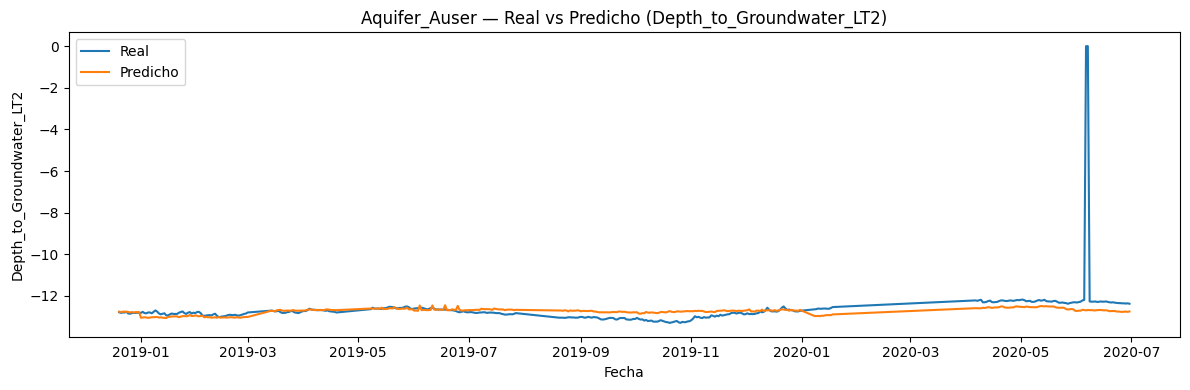

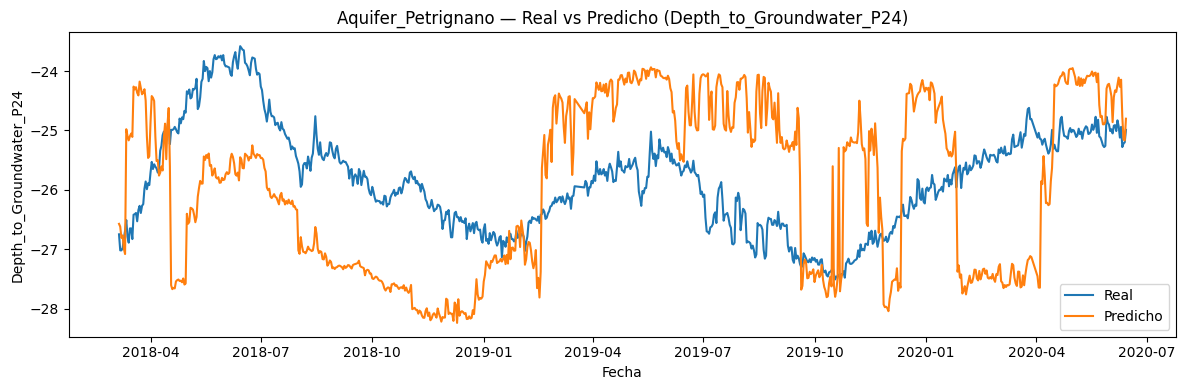

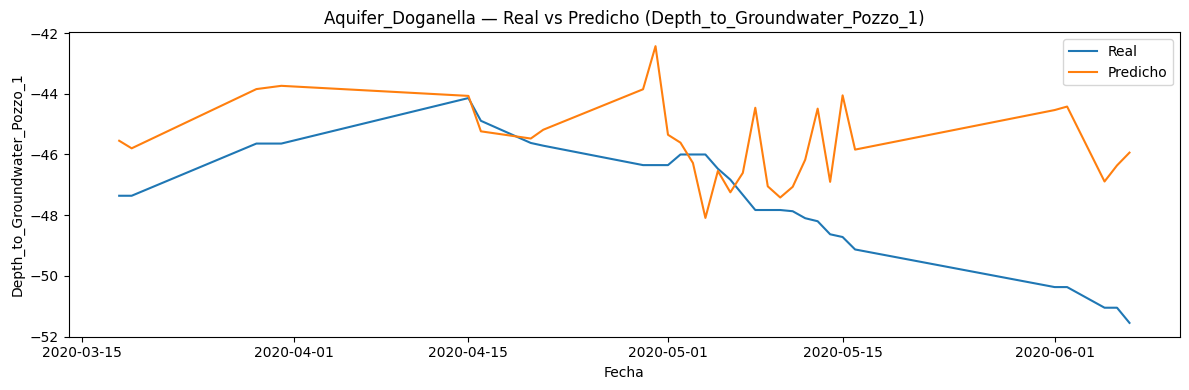

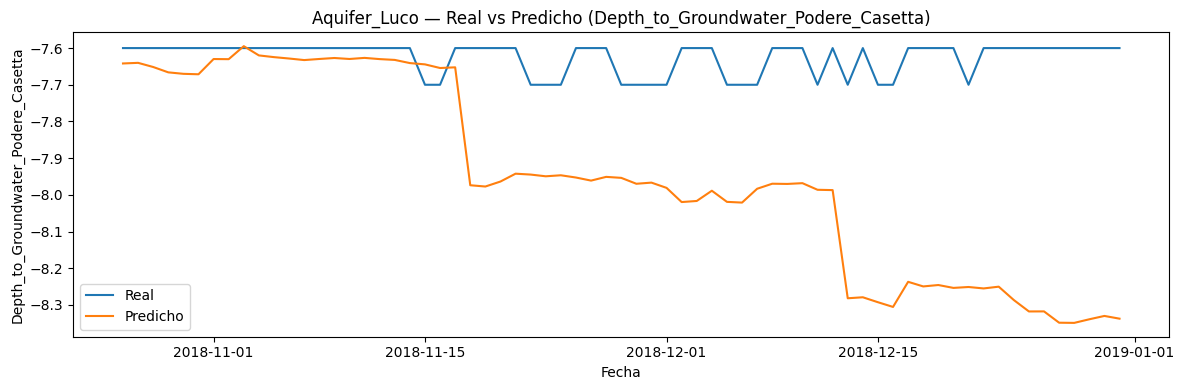

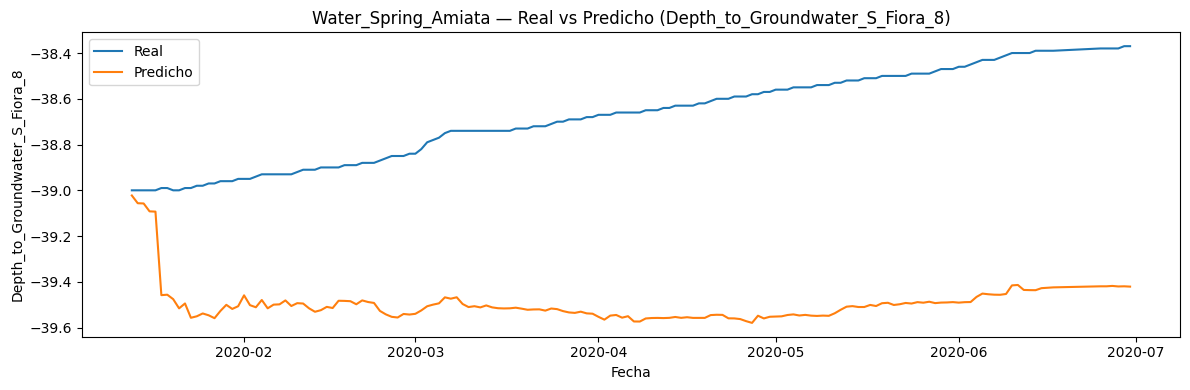

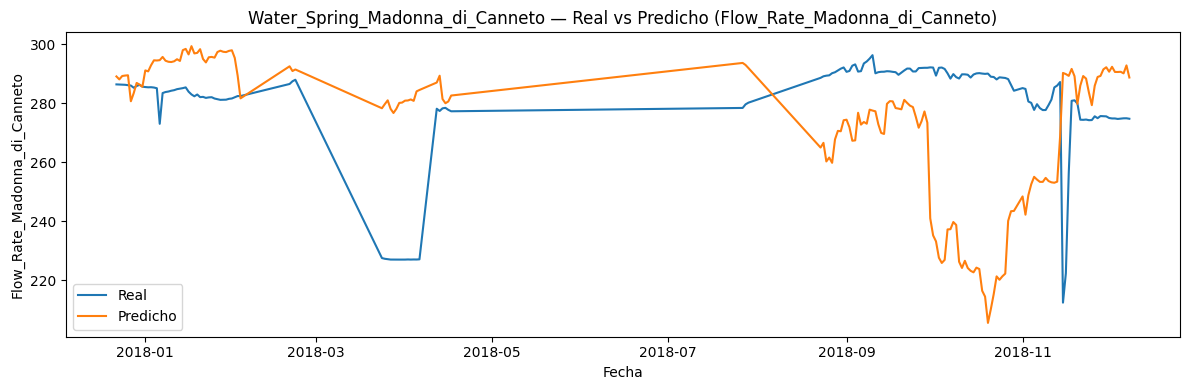

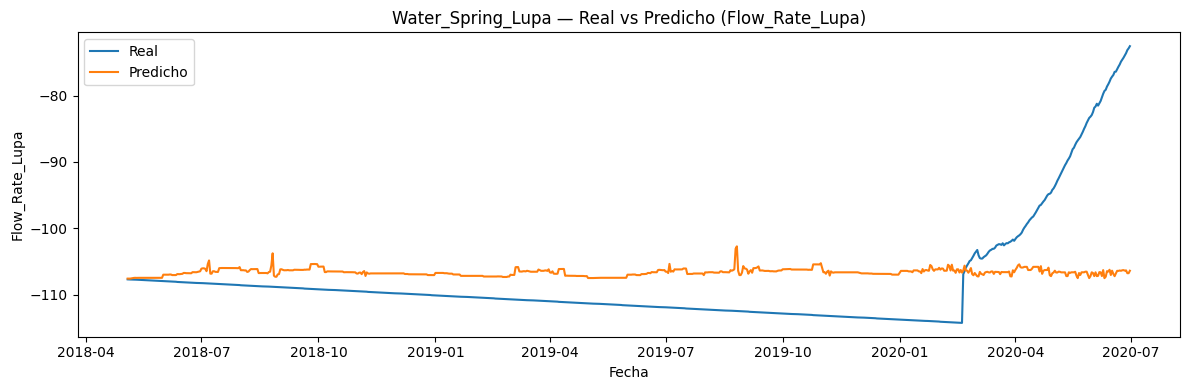

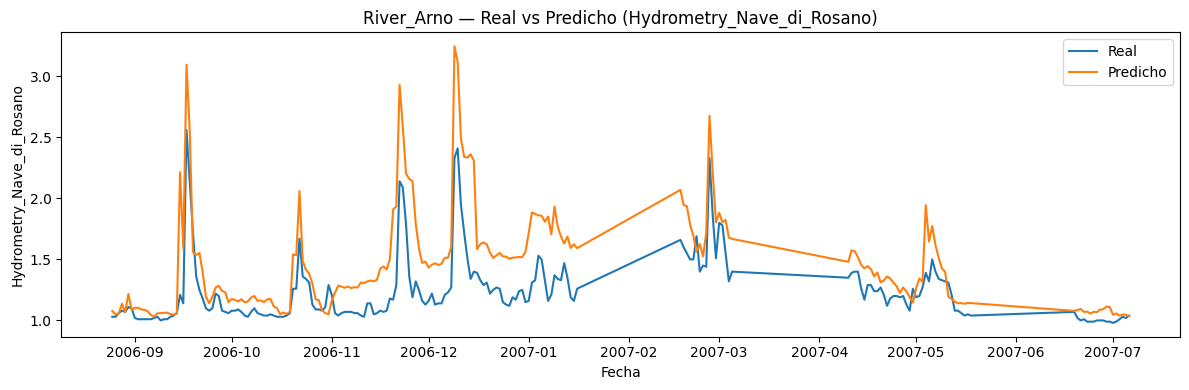

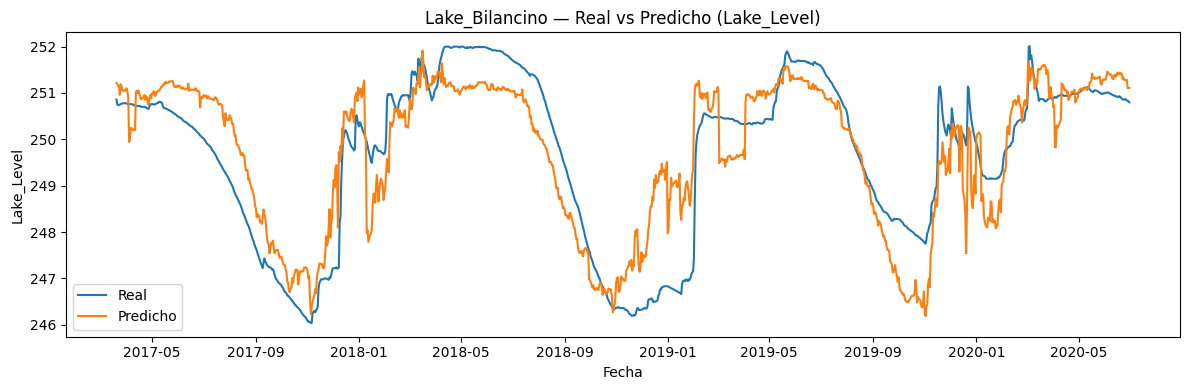

In [11]:
import matplotlib.pyplot as plt

# Se grafica un ejemplo por waterbody (primer target detectado) para validar visualmente la calidad del ajuste.
def plot_real_vs_pred(name: str):
    train_df, test_df, y_test, y_pred = artifacts[name]["pack"]
    t = artifacts[name]["artifact"]["targets"][0]
    date_col = artifacts[name]["artifact"]["date_col"]

    # Asegurar alineación: mismo orden que y_test/y_pred
    # 1) Intento: usar el índice como label (loc)
    try:
        dates_test = test_df.loc[y_test.index, date_col]
    except Exception:
        # 2) Fallback: resetear índice y usar posiciones (iloc)
        test_df_reset = test_df.reset_index(drop=True)
        y_test_reset = y_test.reset_index(drop=True)
        dates_test = test_df_reset[date_col].iloc[y_test_reset.index]

    plt.figure(figsize=(12, 4))
    plt.plot(dates_test.values, y_test[t].values, label="Real")
    plt.plot(dates_test.values, y_pred[t].values, label="Predicho")
    plt.title(f"{name} — Real vs Predicho ({t})")
    plt.xlabel("Fecha")
    plt.ylabel(t)
    plt.legend()
    plt.tight_layout()
    plt.show()

for name in raw.keys():
    plot_real_vs_pred(name)


## 7) Resumen de métricas (MAE/RMSE)

In [12]:
# Se resume el desempeño promedio por waterbody (promedio de targets).
summary_metrics = (
    metrics_table
    .groupby("waterbody")[["MAE","RMSE"]]
    .mean()
    .sort_values("RMSE")
)
summary_metrics


,MAE,RMSE
waterbody,,
River_Arno,0.229813,0.308136
Aquifer_Auser,0.248124,0.510566
Aquifer_Petrignano,0.970510,1.077460
Aquifer_Luco,0.822210,1.093941
Aquifer_Doganella,1.534247,1.741590
Lake_Bilancino,1.091023,1.955816
Water_Spring_Amiata,1.895818,1.956691
Water_Spring_Lupa,5.979309,8.409535
Water_Spring_Madonna_di_Canneto,26.589636,34.353883


## 8) Guardado de modelos con joblib

In [13]:
# Se guardan los modelos (pipeline + metadata) con joblib en la carpeta models/.
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

for name, obj in artifacts.items():
    artifact = obj["artifact"]
    out_path = models_dir / f"{name}_model.joblib"
    joblib.dump(artifact, out_path)
    print("✅ Modelo guardado en:", out_path)


✅ Modelo guardado en: models/Aquifer_Auser_model.joblib
✅ Modelo guardado en: models/Aquifer_Petrignano_model.joblib
✅ Modelo guardado en: models/Aquifer_Doganella_model.joblib
✅ Modelo guardado en: models/Aquifer_Luco_model.joblib
✅ Modelo guardado en: models/Water_Spring_Amiata_model.joblib
✅ Modelo guardado en: models/Water_Spring_Madonna_di_Canneto_model.joblib
✅ Modelo guardado en: models/Water_Spring_Lupa_model.joblib
✅ Modelo guardado en: models/River_Arno_model.joblib
✅ Modelo guardado en: models/Lake_Bilancino_model.joblib


## 9) Cómo reutilizar un modelo guardado

Para usar un modelo guardado:

1. Se carga el artefacto con `joblib.load`.
2. Se prepara un dataframe nuevo con la misma lógica (fecha → features temporales + lags).
3. Se hace `pipeline.predict(X_nuevo)`.

En producción, lo ideal es encapsular la preparación de features en una función compartida para garantizar consistencia.


In [15]:
from pathlib import Path
import joblib
import pandas as pd

# Ejemplo: cargar un modelo y predecir sobre las últimas filas del mismo dataset
example_name = "River_Arno"
loaded = joblib.load(Path("models") / f"{example_name}_model.joblib")

print("Waterbody:", loaded["waterbody"])
print("Targets:", loaded["targets"][:5], "...")
print("N_features:", len(loaded["feature_columns"]))

# Se rehace el feature engineering sobre el dataset original para predecir.
df_raw = raw[example_name].copy()
date_col = loaded["date_col"]

# ✅ FIX: parseo robusto de fechas (dd/mm/yyyy típico en estos datasets)
df_raw[date_col] = pd.to_datetime(df_raw[date_col], dayfirst=True, errors="coerce")

# Validación: si algo quedó como NaT, se avisa con ejemplos reales
if df_raw[date_col].isna().any():
    ejemplos = df_raw.loc[df_raw[date_col].isna(), date_col].head(10).tolist()
    raise ValueError(
        f"[{example_name}] No se pudieron parsear algunas fechas en '{date_col}'. "
        f"Ejemplos (raw): {ejemplos}"
    )

df_raw = df_raw.sort_values(date_col).reset_index(drop=True)

# Se replican los pasos de features.
df_feat = add_time_features(df_raw, date_col=date_col)
if len(loaded["exog_cols"]) > 0:
    df_feat = add_lag_features(df_feat, cols=loaded["exog_cols"], lags=(1,7,14,30), rolls=(7,30))
df_feat = df_feat.dropna().reset_index(drop=True)

# Se arma X con las mismas columnas usadas en entrenamiento.
X = df_feat.drop(columns=[date_col] + loaded["targets"])
X = X[loaded["feature_columns"]]

# Se predicen las últimas 5 observaciones.
pred = loaded["pipeline"].predict(X.tail(5))
pred = pd.DataFrame(pred, columns=loaded["targets"])
pred



Waterbody: River_Arno
Targets: ['Hydrometry_Nave_di_Rosano'] ...
N_features: 112


,Hydrometry_Nave_di_Rosano
0,1.057528
1,1.039551
2,1.048932
3,1.046789
4,1.034352
